## Import Dependencies

In [1]:
import os
import copy

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

## Set Up

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU can accomodate greater image sizes and faster image synthesis

## Load and Process Images

In [3]:
image_dir = "./static"

In [4]:
def load_image(image_path, size=(128, 128)): # using default size for CPU
    image = Image.open(image_path)
    
    loader = transforms.Compose([
        transforms.Resize(size),  # resize
        transforms.ToTensor()])  # transform image into tensor

    image = loader(image).unsqueeze(0) # models in torch.nn requires inputs with a batch dimension
    return image.to(device, torch.float)


def show_image(tensor, title=None):
    image = tensor.cpu().clone()  # clone the tensor to avoid modifying the original
    
    if image.dim() == 4:
        image = image.squeeze(0) # remove artificial batch dimension
    
    image = transforms.ToPILImage()(image)
    plt.imshow(image)

    if title:
        plt.title(title)
    plt.pause(0.01)

In [5]:
image_size = (128, 128)
content_image = load_image(os.path.join(image_dir, "content_image.jpeg"), image_size)
style_image = load_image(os.path.join(image_dir, "style_reference.jpeg"), image_size)

print('content image shape: ', content_image.size())
print('style image shape: ', style_image.size())

content image shape:  torch.Size([1, 3, 128, 128])
style image shape:  torch.Size([1, 3, 128, 128])


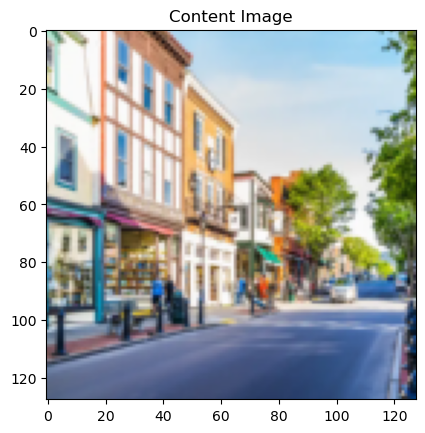

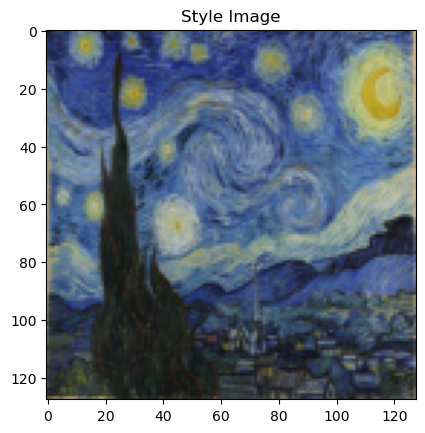

In [6]:
show_image(content_image, "Content Image")
show_image(style_image, "Style Image")

## Gram Matrix

In [7]:
# A Gram matrix is the result of multiplying a matrix by its transpose.
# Since our inputs will by pytorch tensors, we first need to manipulate the shape of the tensor to become a 2D matrix
# before performing matrix multiplication.

# Since the style features of an image are in the higher layers of the network, 
# the resulting matrix must be normalized to reduce influence of the first layers during gradient descent.


def gram_matrix(input):
    '''
    Computes the Gram matrix of a tensor.
    '''
    print("calculating gram matrix...")

    if input.dim() == 3:
        input = input.unsqueeze(0)  # input must have an artificial batch dimension

    shape = input.size()
    # print("input shape: ", shape)

    try:
        reshaped = input.view(shape[0] * shape[1], shape[2] * shape[3])  # flatten tensor into 2D
        
        # multiply matrix by its transpose to compute the gram product
        result = torch.mm(reshaped, reshaped.t())

        # normalize the matrix to scale each value within 0-1
        result = result.div(shape[0] * shape[1] * shape[2] * shape[3])
        return result

    except IndexError:
        print("Input tensor must have 4 dimensions. Received {}D tensor instead".format(len(shape)))

In [8]:
test_res = gram_matrix(style_image)

calculating gram matrix...


### Style Loss

In [9]:
# create the style and content loss as modules to add them into the model

class StyleLoss(nn.Module):
    
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()  # the target must be detached to compute the gradient since it needs to be a static value

    def forward(self, input):  # defines the computation (forward propagation) the module performs on the input
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    # back propagation method is defined automatically

### Content Loss

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
    
        self.loss = F.mse_loss(input, self.target)
        return input

## Normalization

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]" (https://pytorch.org/vision/0.8/models.html)

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# normalization module to normalize input images for the VGG-19 model
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input):
        return (input - self.mean) / self.std # normalization formula

## L-BFGS Optimizer

We will use the L-BFGS optimizer to optimize the input image's features to minimize the style/content loss. Notice how this differs from the usual application of optimizing model params. 

In [12]:
def lbfgs_optimizer(input):
    optimizer = torch.optim.LBFGS([input.requires_grad_()]) # records operations applied to the input image
    return optimizer

## Preparing the Model

The paper only uses the first module of the VGG-19 model (features), which contains the convolution and pooling layers to extract the content and style representations. The classifier module in not needed as we are not performing any image classification.

Note: we will use the model in evaluation mode (.eval()) since it may behave different in evaluation vs. training.

In [13]:
# see summary of model
!pip install torchsummary

In [14]:
from torchsummary import summary

In [15]:
vgg_network = models.vgg19(weights='DEFAULT').features.to(device).eval()
summary(vgg_network, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
# layers used in the paper to determine content/style representations
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

last_layer = 'conv_5'  # Losses stop being calculated after this layer

def get_model_and_losses(network, style_image, content_image, mean=mean, std=std, content_layers=content_layers, style_layers=style_layers):
    network = copy.deepcopy(network)
    normalization = Normalize(mean, std).to(device)

    # make a new sequential model with custom loss/normalization modules
    nst_model = nn.Sequential(normalization)

    style_losses = []
    content_losses = []

    idx = 0
    for layer in network.children():

        # check type of layer
        if isinstance(layer, nn.Conv2d):
            name = 'conv_'
            idx += 1
        elif isinstance(layer, nn.ReLU):
            name = 'relu_'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'
        else:
            raise RuntimeError('Processing invalid layer: {}'.format(layer.__class__.__name__))

        name += str(idx)
        print('adding layer: ', name)
        nst_model.add_module(name, layer)

        if name in content_layers:
            target = nst_model(content_image).detach()
            print('target shape: ', target.size())
            
            content_loss = ContentLoss(target)
            print('content loss: ', content_loss)
            
            nst_model.add_module("content_loss_{}".format(idx), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = nst_model(style_image).detach()
            print('target shape: ', target.size())
            
            style_loss = StyleLoss(target)
            print('style loss: ', style_loss)
            
            nst_model.add_module("style_loss_{}".format(idx), style_loss)
            style_losses.append(style_loss)

        if name == last_layer:
            break

    return nst_model, style_losses, content_losses

## Preparing Images

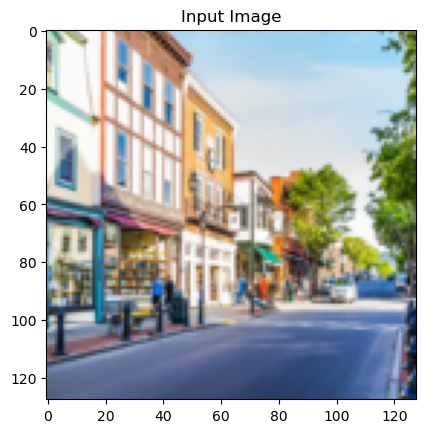

In [17]:
input_image = content_image.clone()  # we will use the content image as input

plt.figure()
show_image(input_image, title='Input Image')

## Apply the Algorithm

In [18]:
def style_transfer(network, input, content_image, style_image, mean=mean, std=std, 
                   steps=300, style_weight=20000, content_weight=100):
    print('building the model...')
    model, style_losses, content_losses = get_model_and_losses(network, style_image, content_image)

    print('getting the optimizer...')
    optimizer = lbfgs_optimizer(input)

    print('performing style transfer...')
    i = 0
    while i <= steps:

        def closure():
            input_image.data.clamp_(0, 1)  # bound the input tensor

            optimizer.zero_grad()
            model(input_image)
            
            style_loss = 0
            content_loss = 0

            for loss in style_losses:
                style_loss += loss.loss
            for loss in content_losses:
                content_loss += loss.loss

            style_loss *= style_weight
            content_loss *= content_weight

            total_loss = style_loss + content_loss
            print('total loss: ', total_loss)
            
            total_loss.backward()  # Compute the gradient
            print('total loss after back propagation: ', total_loss)
            return total_loss

        print('=============== step {}/{} ==============='.format(i, steps))
        optimizer.step(closure)
        i += 1
        
    input.data.clamp_(0, 1)
    return input

In [19]:
result = style_transfer(vgg_network, input_image, content_image, style_image)

building the model...
adding layer:  conv_1
target shape:  torch.Size([1, 64, 128, 128])
calculating gram matrix...
style loss:  StyleLoss()
adding layer:  relu_1
adding layer:  conv_2
calculating gram matrix...
target shape:  torch.Size([1, 64, 128, 128])
calculating gram matrix...
style loss:  StyleLoss()
adding layer:  relu_2
adding layer:  pool_2
adding layer:  conv_3
calculating gram matrix...
calculating gram matrix...
target shape:  torch.Size([1, 128, 64, 64])
calculating gram matrix...
style loss:  StyleLoss()
adding layer:  relu_3
adding layer:  conv_4
calculating gram matrix...
calculating gram matrix...
calculating gram matrix...
target shape:  torch.Size([1, 128, 64, 64])
content loss:  ContentLoss()
calculating gram matrix...
calculating gram matrix...
calculating gram matrix...
target shape:  torch.Size([1, 128, 64, 64])
calculating gram matrix...
style loss:  StyleLoss()
adding layer:  relu_4
adding layer:  pool_4
adding layer:  conv_5
calculating gram matrix...
calcula

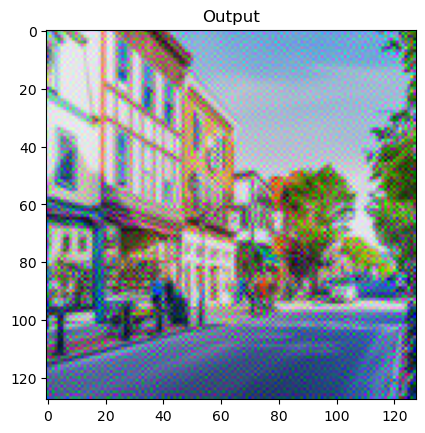

In [20]:
plt.figure()
show_image(result, title='Output')